# Prediction of Credit Card Default for Taiwanese Customers

# Contents

- <a href='#1'>Introduction</a>
- <a href='#2'>Importing Packages</a>  
- <a href='#3'>Uploading Data</a>
- <a href='#4'>Creating Train, Validation, and Testing Sets</a>  
- <a href='#5'>Data Cleaning</a>  
- <a href='#5'>Exploratory Data Analysis</a>
- <a href='#6'>Feature Engineering</a>  

# Introduction

This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card customers in Taiwan from April 2005 to September 2005.


There are 25 variables:

- ID: ID of each client
- LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
- SEX: Gender
    - 1=male
    - 2=female
- EDUCATION:
    - 1=graduate school
    - 2=university
    - 3=high school
    - 4=others
    - 5=unknown
    - 6=unknown
- MARRIAGE: Marital status
    - 1=married
    - 2=single
    - 3=others)
- AGE: Age in years
- PAY_0: Repayment status in September, 2005
    - -1=pay duly
    - 1=payment delay for one month
    - 2=payment delay for two months
    ....
    - 8=payment delay for eight months
    - 9=payment delay for nine months and above
- PAY_2: Repayment status in August, 2005 (scale same as above)
- PAY_3: Repayment status in July, 2005 (scale same as above)
- PAY_4: Repayment status in June, 2005 (scale same as above)
- PAY_5: Repayment status in May, 2005 (scale same as above)
- PAY_6: Repayment status in April, 2005 (scale same as above)
- BILL_AMT1: Amount of bill statement in September,2005 (NT dollar)
- BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
- BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
- BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
- BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
- BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
- PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
- PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
- PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
- PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
- PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
- PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
- default.payment.next.month: Default payment
    - 1=yes
    - 0=no

# Importing Packages

In [2]:
# Importing Packages
import numpy as np 
import pandas as pd
import re
import json
import requests
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline
plt.style.use("fivethirtyeight")
import pickle

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, classification_report,balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

%reload_ext autoreload
%autoreload 2
from utils import *

In [3]:
df = pd.read_excel("data/default of credit card clients.xls")
new_header = df.iloc[0]
df = df[1:] 
df.columns = new_header
df = df.rename(columns={"default payment next month": "default"}) 

# Create Dataset Splits

In [4]:
X = df.drop(["default"], axis=1)
y = df["default"]
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)
X_tr, X_tt, y_tr, y_tt = train_test_split(X_train, y_train, train_size=0.875, random_state=42)
train = pd.concat([X_tr, y_tr], axis=1)
val = pd.concat([X_val, y_val], axis=1)
tr = train.drop(["ID"], axis=1)
val = val.drop(["ID"], axis=1)

# Data Cleaning

- The data cleaning process involved coonverting Taiwanese dollars to American dollars to facilitate understanding of the numbers involved and then converting them into integers.
- There were anomalous values in the marriage category, so observations with the value of 0 were converted into 3, which represented other.
- There were anomalous values in the education category, so observations with the value of 0, 5, or 6 were all lumped into the 4 or other category.
- In the behind1 - behind6 categories, I was originally going to convert all the observations with the negative values into 0, but since there were so many observations with -1 and -2, it couldn't have been an anomaly or mistake.



In [5]:
url = 'https://openexchangerates.org/api/latest.json?app_id=c51b1508fb4145259b1c2fade72a2c04'
response = requests.get(url)
data = response.json()
rate = data['rates']['TWD']

In [6]:
data = [tr, val]
for d in data:
    d.rename(columns={"PAY_0": "behind1", "PAY_2": "behind2", "PAY_3": "behind3", "PAY_4": "behind4", "PAY_5": "behind5", "PAY_6": "behind6", "BILL_AMT1": "billed1", "BILL_AMT2": "billed2", "BILL_AMT3": "billed3", "BILL_AMT4": "billed4", "BILL_AMT5": "billed5", "BILL_AMT6": "billed6", "PAY_AMT1": "paid1", "PAY_AMT2": "paid2", "PAY_AMT3": "paid3", "PAY_AMT4": "paid4", "PAY_AMT5": "paid5", "PAY_AMT6": "paid6", "SEX": "gender", "EDUCATION": "education", "MARRIAGE": "marriage", "AGE": "age", "LIMIT_BAL": "limit"}, inplace=True)
    d[['limit']] = d[['limit']]/rate
    d[['billed1', 'billed2', 'billed3', 'billed4', 'billed5', 'billed6']] = d[['billed1', 'billed2', 'billed3', 'billed4', 'billed5', 'billed6']].divide(rate, axis=1).astype(int)
    d[['paid1', 'paid2', 'paid3', 'paid4', 'paid5', 'paid6']] = d[['paid1', 'paid2', 'paid3', 'paid4', 'paid5', 'paid6']].divide(rate, axis=1).astype(int)
    d['limit'] = d['limit'].apply(lambda x: round(x, 2))
    d.replace({'marriage': {0:3}}, inplace=True)
    d.replace({'education': {5:4, 0:4, 6:4}}, inplace=True)

In [7]:
tr.head()

,limit,gender,education,marriage,age,behind1,behind2,behind3,behind4,behind5,behind6,billed1,billed2,billed3,billed4,billed5,billed6,paid1,paid2,paid3,paid4,paid5,paid6,default
6191,1788.52,2,2,1,44,0,0,0,0,0,0,1630,1498,1277,799,846,980,107,178,107,107,178,33,0
16054,5723.26,2,3,1,46,-1,-1,-1,0,-1,-1,890,83,173,147,142,30,83,173,35,142,30,941,0
19706,3577.04,2,2,1,47,-1,-1,-1,-1,-1,-2,238,238,0,224,-14,-14,238,0,224,0,0,0,1
23128,6080.96,2,2,1,29,0,0,0,0,0,0,2829,2238,2264,2285,1556,1573,79,89,92,60,67,75,0
28516,5365.56,2,1,2,33,-2,-2,-2,-2,-2,-2,872,960,1169,1196,994,80,966,1170,1197,994,80,6061,0


In [8]:
tr.describe()

,limit,education,marriage,billed1,billed2,billed3,billed4,billed5,billed6,paid1,paid2,paid3,paid4,paid5,paid6
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.00000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,5981.340686,1.842810,1.555333,1827.979905,1758.19519,1679.613952,1543.949857,1443.855667,1393.781810,204.618429,214.418048,188.432952,175.843714,172.090667,184.061095
std,4634.450783,0.746378,0.522538,2628.013848,2545.94903,2489.800493,2299.447009,2182.100061,2134.592138,626.349241,897.321096,667.001026,601.041739,558.702990,631.634456
min,357.700000,1.000000,1.000000,-5922.000000,-2495.00000,-5625.000000,-6080.000000,-2909.000000,-7477.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1788.520000,1.000000,1.000000,127.000000,108.00000,98.000000,84.000000,63.000000,46.000000,35.000000,29.000000,13.000000,10.000000,8.000000,4.000000
50%,5007.850000,2.000000,2.000000,803.000000,766.00000,717.500000,680.500000,647.000000,612.000000,75.000000,71.000000,64.000000,53.000000,53.000000,53.000000
75%,8584.890000,2.000000,2.000000,2387.250000,2263.50000,2135.000000,1943.250000,1798.000000,1767.000000,179.000000,178.000000,160.000000,143.000000,144.000000,143.000000
max,35770.370000,4.000000,3.000000,34500.000000,35195.00000,59525.000000,31892.000000,33165.000000,34399.000000,31247.000000,60246.000000,32051.000000,22213.000000,14951.000000,18856.000000


** Observations: **

- No missing data
- There were anomalous values for education and marriage, and the anomalous values were reassigned under other.
- Did not reassign -2 and -1 to 0 for 'behind' features despite being anomalous because they were so many -2 and -1.  There must be so significance to those values.

# Exploratory Data Anlaysis

In [9]:
# organize features into categorical and continuous
categorical = tr[['gender', 'marriage', 'education', 'behind1', 'behind2', 'behind3', 'behind4', 'behind5', 'behind6']]
continuous = tr[['limit', 'age', 'billed1', 'billed2', 'billed3', 'billed4', 'billed5', 'billed6', 'paid1', 'paid2', 'paid3', 'paid4', 'paid5', 'paid6']]
cat_col = categorical.columns
cont_col = continuous.columns

In [10]:
# display distributions of all the continuous variables

# con_1 = pd.melt(tr, value_vars = cont_col)
# sns.set_theme(style="darkgrid", font='serif', context='talk')
# g = sns.FacetGrid(con_1, col='variable', col_wrap=3, sharex=False, sharey=False, height=4)
# g = g.map(sns.distplot, 'value', color='r')
# g.set_xticklabels(rotation=45)
# g.fig.subplots_adjust(top=0.9)
# g.fig.suptitle("Distributions of Continuous Features")
# g.fig.tight_layout()
# plt.savefig("../images/distplot.png")

<img src="images/distplot.png">

** Observations: **

- It is hard to observe any trends with the paid features. 

In [11]:
# Use bar graphs of the distribution of data for categorical variables

# cat_1 = pd.melt(tr, value_vars=cat_col)
# sns.set_theme(style="darkgrid", font='serif', context='talk')
# g = sns.FacetGrid(cat_1, col='variable', col_wrap=3, sharex=False, sharey=False, height=4)
# g = g.map(sns.countplot, 'value', color='dodgerblue')
# g.set_xticklabels()
# g.fig.subplots_adjust(top=0.9)
# g.fig.suptitle("Distributions of Categorical Features")
# g.fig.tight_layout()
# plt.savefig("../images/countplot.png")

<img src="images/countplot.png">

In [12]:
yes = tr.default.sum()
no = len(tr)-yes
perc_y = round(yes/len(tr)*100, 1)
perc_n = round(no/len(tr)*100, 1)

# plt.figure(figsize=(8,6))
# sns.set_theme(style="darkgrid", font='serif', context='talk')
# sns.countplot('default', data=tr)
# plt.title('Credit Card Baseline Default', size=16)
# plt.box(False);
# plt.savefig("../images/baseline.png")

<img src="images/baseline.png">

- There is class inbalance in the dataset.  Our baseline indicates 

In [14]:
print("Number of Total Non-Defaulters: ", yes)
print("Number of Defaulters: ", no)
print("Percentage of Non-Defaulters: ", perc_y)
print("Percentage of Defaulters: ", perc_n)

pd.DataFrame
default = pd.DataFrame(data = {"Training Dataset": [yes, no, perc_y, perc_n]}, 
                       index = ["Number of Total Non-Defaulters: ", "Number of Defaulters: ", "Percentage of Non-Defaulters: ", "Percentage of Defaulters: "])
default

Number of Total Non-Defaulters:  4656
Number of Defaulters:  16344
Percentage of Non-Defaulters:  22.2
Percentage of Defaulters:  77.8


,Training Dataset
Number of Total Non-Defaulters:,4656.0
Number of Defaulters:,16344.0
Percentage of Non-Defaulters:,22.2
Percentage of Defaulters:,77.8


In [15]:
# subset = tr[['gender', 'education', 'marriage', 'behind1', 'behind2', 'behind3', 'behind4', 'behind5', 'behind6', 'default']]
# f, axes = plt.subplots(3, 3, figsize=(15, 12), facecolor='white')
# sns.set_theme(style="darkgrid", font='serif', context='paper')
# f.suptitle('Frequency of Categorical Variables', size=16)
# ax1 = sns.countplot(x="gender", hue="default", data=subset, ax=axes[0,0])
# ax2 = sns.countplot(x="education", hue="default", data=subset, ax=axes[0,1])
# ax3 = sns.countplot(x="marriage", hue="default", data=subset, ax=axes[0,2])
# ax4 = sns.countplot(x="behind1", hue="default", data=subset, ax=axes[1,0])
# ax5 = sns.countplot(x="behind2", hue="default", data=subset, ax=axes[1,1])
# ax6 = sns.countplot(x="behind3", hue="default", data=subset, ax=axes[1,2])
# ax7 = sns.countplot(x="behind4", hue="default", data=subset, ax=axes[2,0])
# ax8 = sns.countplot(x="behind5", hue="default", data=subset, ax=axes[2,1])
# ax9 = sns.countplot(x="behind6", hue="default", data=subset, ax=axes[2,2])
# plt.savefig("../images/default_freq_by_cat.png")

<img src="images/default_freq_by_cat.png">

** Observations: **

- `gender`, `education`, and `marriage` doesn't seem to change with each group in terms of proportions.  Behind seems to have some correlation with default.  That would make sense since being behind in payments would make it more likely that you would default next month. 

- There isn’t a very clear distinction between the distribution of `default` on any of the demographic data. However, you do see quite some distribution differences of target classes for monthly repayment status (`behind1`-`behind6`).



In [16]:
education = tr.groupby(['education', 'default']).size().unstack(1)
education
# education.plot(kind="bar", stacked=True)
# plt.title("Distribution Count of Educational Level and Default Status", size=14)
# plt.savefig("../data/stacked_bar2.png")

default,0,1
education,,
1,6013,1424
2,7408,2341
3,2626,866
4,297,25


<img src="images/stacked_bar2.png">

** No clear relationship with education. The proportion doesn't seem to change with each group. **

In [17]:
marriage = tr.groupby(['marriage', 'default']).size().unstack(1)
marriage
# marriage.plot(kind="bar", stacked=True)
# plt.title("Distribution of Default Status for Marital Status", size=14)
# plt.savefig("../images/stacked_bar3.png")

default,0,1
marriage,,
1,7354,2258
2,8778,2336
3,212,62


<img src="images/stacked_bar3.png">

# Vanilla Model

In [ ]:
logreg = LogisticRegression(solver="liblinear", random_state=42).fit(X_tr_dum, y_tr)
y_pred_log_tr = logreg.predict(X_tr_dum)
y_pred_log_val = logreg.predict(X_val_dum)

rfc = RandomForestClassifier().fit(X_tr, y_tr)
y_pred_rfc_tr = rfc.predict(X_tr)
y_pred_rfc_val = rfc.predict(X_val)

dtc = DecisionTreeClassifier().fit(X_tr, y_tr)
y_pred_dtc_tr = dtc.predict(X_tr)
y_pred_dtc_val = dtc.predict(X_val)

knn = KNeighborsClassifier().fit(X_tr, y_tr)
y_pred_knn_tr = knn.predict(X_tr)
y_pred_knn_val = knn.predict(X_val)

gnb = GaussianNB().fit(X_tr, y_tr)
y_pred_gnb_tr = gnb.predict(X_tr)
y_pred_gnb_val = gnb.predict(X_val)

lda = LinearDiscriminantAnalysis().fit(X_tr, y_tr)
y_pred_lda_tr = lda.predict(X_tr)
y_pred_lda_val = lda.predict(X_val)

abc = AdaBoostClassifier().fit(X_tr, y_tr)
y_pred_abc_tr = abc.predict(X_tr)
y_pred_abc_val = abc.predict(X_val)

gbc = GradientBoostingClassifier().fit(X_tr, y_tr)
y_pred_gbc_tr = gbc.predict(X_tr)
y_pred_gbc_val = gbc.predict(X_val)

xgb = XGBClassifier().fit(X_tr, y_tr)
y_pred_xgb_tr = xgb.predict(X_tr)
y_pred_xgb_val = xgb.predict(X_val)


In [18]:
baseline = pd.read_csv("data/charts/baseline.csv")
baseline

,Unnamed: 0,Accuracy,F1 Score,Recall,Precision,PR AUC
0,Logistic Regression,0.811500,0.360656,0.242955,0.699561,0.486829
1,Random Forest Classifier,0.814833,0.461464,0.362529,0.634667,0.513445
2,Decision Tree Classifier,0.730667,0.399257,0.408987,0.389978,0.289090
3,K-Nearest Neighbors,0.798000,0.447080,0.373191,0.557452,0.416605
4,Gaussian Naive Bayes,0.724000,0.498486,0.626809,0.413776,0.480981
5,Linear Discriminant Analysis,0.810333,0.367778,0.252094,0.679671,0.480476
6,AdaBoost Classifier,0.815667,0.425753,0.312262,0.668842,0.523430
7,Gradient Boosting Classifier,0.820833,0.468085,0.360244,0.668079,0.545925
8,XGBoost Classifier,0.816833,0.469338,0.370145,0.641161,0.518488


# Feature Engineering

- `age_bin`: 1 = young adult, 2 = middle age, 3 = senior
- `gen-mar`: interaction between gender and marriage status
- `gen-age`: interaction between age and gender
- 'avail...`: fraction of estimated available balance based on what is billed per month

In [19]:
data = [tr, val]

# create features for demographic variables
for d in data:
    d['age_bin'] = 0
    d.loc[((d['age'] > 20) & (d['age'] < 30)) , 'age_bin'] = 1
    d.loc[((d['age'] >= 30) & (d['age'] < 60)) , 'age_bin'] = 2
    d.loc[((d['age'] >= 60) & (d['age'] < 81)) , 'age_bin'] = 3
    # create categories for single, married, divorced males and females
    d['gen-mar'] = d['gender'] + d['marriage']
    # create categories for young, middle age and senior males and females
    d['gen-age'] = d['gender'] + d['age_bin']

# feature for credit use percentage: fraction of estimated available balance based on what is billed per month
# (credit limit - monthly billed amount) / credit limit
for d in data:
    d['avail6'] = (d.limit - d.billed6) / d.limit
    d['avail5'] = (d.limit - d.billed5) / d.limit
    d['avail4'] = (d.limit - d.billed4) / d.limit
    d['avail3'] = (d.limit - d.billed3) / d.limit
    d['avail2'] = (d.limit - d.billed2) / d.limit
    d['avail1'] = (d.limit - d.billed1) / d.limit
    d['avg_av'] = (d.avail1 + d.avail2 + d.avail3 + d.avail4 + d.avail5 + d.avail6) / 6

# create a feature that indicates whether a client has had a delayed payment or not
def delayed_payment(d):
    if (d.behind1 > 0) or (d.behind2 > 0) or (d.behind3 > 0) or (d.behind4 > 0) or (d.behind5 > 0) or (d.behind6 > 0):
        return 1
    else:
        return 0
for d in data:
    d['delayed'] = d.apply(delayed_payment, axis=1)

# create feature for the total number of months with delayed payment status for a particular client
def total_months_with_delayed_payments(d):
    count = 0
    if (d.behind1 > 0):
        count += 1
    if (d.behind2 > 0):
        count += 1
    if (d.behind3 > 0):
        count += 1
    if (d.behind4 > 0):
        count += 1
    if (d.behind5 > 0):
        count += 1
    if (d.behind6 > 0):
        count += 1
    return count
for d in data:
    d['latemths'] = d.apply(total_months_with_delayed_payments, axis=1)

# the ratio of amount paid and amount billed
for d in data:
    d['pperb1'] = d.paid1 / d.billed2
    d['pperb2'] = d.paid2 / d.billed3
    d['pperb3'] = d.paid3 / d.billed4
    d['pperb4'] = d.paid4 / d.billed5
    d['pperb5'] = d.paid5 / d.billed6

# remove any infinity and NaN values
datasets = ['pperb1', 'pperb2', 'pperb3', 'pperb4', 'pperb5']
for data in datasets:
    tr.replace({data: {np.inf: 0, np.nan: 0}}, inplace=True)
    val.replace({data: {np.inf: 0, np.nan: 0}}, inplace=True)

In [20]:
# plt.style.use("fivethirtyeight")
# sns.set_theme(style="darkgrid", font='serif', context='paper')
# plt.figure(figsize = (20,16))
# plt.title('Pearson Correlation of Features', y = 1.05, size = 20)
# g = sns.heatmap(tr.corr(), cmap='RdBu', square=True, linecolor='white', linewidths=0.2)
# plt.savefig("../images/correlation_matrix_2.png")


<img src="images/correlation_matrix_2.png">

** This includes my engineered features.  Default seems to be correlated with two of my engineered features, delayed and latemnths.  Delayed is whether you have had a delayed payment durig the 6 month history or not. latemnths is the total nunber of months you were given a status of behind in payments.  Seems to be correlated with behind1 and limit.**

In [22]:
pickle_in = open("data/pickles/training_features.pickle","rb")
train2 = pickle.load(pickle_in)
pickle_in = open("data/pickles/validate_features.pickle","rb")
validate2 = pickle.load(pickle_in)

In [23]:
X_train2 = train2.drop(["default"], axis=1)
y_tr = train2["default"]
X_validate2 = validate2.drop(["default"], axis=1)
y_val = validate2["default"]

In [24]:
# # Grab indices of columns for creating dummy variables and create dataframe with dummy variables
dum_feat = X_train2[['gender', 'education', 'marriage', 'age_bin', 'gen-mar', 'gen-age']]
dum_index = dum_feat.columns
tr_dum = pd.get_dummies(data=dum_feat, columns=dum_index, drop_first=True, prefix=['sex', 'edu', 'mar', 'agebin', 'sexmar', 'sexage'])
cont_feat = X_train2.drop(['gender', 'education', 'marriage', 'age_bin', 'gen-mar', 'gen-age'], axis=1)
X_train2_dum = cont_feat.join(tr_dum)
X_train2_dum.head()

,limit,age,behind1,behind2,behind3,behind4,behind5,behind6,billed1,billed2,billed3,billed4,billed5,billed6,paid1,paid2,paid3,paid4,paid5,paid6,avail6,avail5,avail4,avail3,avail2,avail1,avg_av,delayed,latemths,pperb1,pperb2,pperb3,pperb4,pperb5,sex_2,edu_2,edu_3,edu_4,mar_2,mar_3,agebin_2,agebin_3,sexmar_3,sexmar_4,sexmar_5,sexage_3,sexage_4,sexage_5
0,1790.26,44,0,0,0,0,0,0,1631.93,1500.45,1278.35,800.60,847.12,981.81,107.99,179.13,107.42,107.42,179.03,33.08,0.451582,0.526817,0.552802,0.285942,0.161882,0.088440,0.344578,0,0,0.071972,0.140126,0.134174,0.126806,0.182347,1,1,0,0,0,0,1,0,1,0,0,0,1,0
1,5728.83,46,-1,-1,-1,0,-1,-1,891.69,83.71,173.87,147.77,143.04,30.15,83.89,173.87,35.81,143.04,30.15,942.14,0.994737,0.975032,0.974206,0.969650,0.985388,0.844350,0.957227,0,0,1.002150,1.000000,0.242336,1.000000,1.000000,1,0,1,0,0,0,1,0,1,0,0,0,1,0
2,3580.52,47,-1,-1,-1,-1,-1,-2,238.68,238.68,0.00,224.50,-14.18,-14.18,238.68,0.00,224.50,0.00,0.00,0.00,1.003960,1.003960,0.937300,1.000000,0.933339,0.933339,0.968650,0,0,1.000000,0.000000,1.000000,-0.000000,-0.000000,1,1,0,0,0,0,1,0,1,0,0,0,1,0
3,6086.88,29,0,0,0,0,0,0,2831.87,2240.51,2267.08,2288.06,1557.71,1575.25,80.02,89.26,92.56,60.26,68.07,75.58,0.741206,0.744087,0.624100,0.627546,0.631912,0.534758,0.650602,0,0,0.035715,0.039372,0.040453,0.038685,0.043212,1,1,0,0,0,0,0,0,1,0,0,1,0,0
4,5370.78,33,-2,-2,-2,-2,-2,-2,873.40,961.26,1170.90,1198.01,995.38,80.96,966.99,1171.37,1198.58,995.67,80.96,6067.73,0.984926,0.814668,0.776939,0.781987,0.821020,0.837379,0.836153,0,0,1.005961,1.000401,1.000476,1.000291,1.000000,1,0,0,0,1,0,1,0,0,1,0,0,1,0


In [25]:
dum_feat2 = X_validate2[['gender', 'education', 'marriage', 'age_bin', 'gen-mar', 'gen-age']]
dum_index2 = dum_feat2.columns
val_dum = pd.get_dummies(data=dum_feat2, columns=dum_index2, drop_first=True, prefix=['sex', 'edu', 'mar', 'agebin', 'sexmar', 'sexage'])
cont_feat2 = X_validate2.drop(['gender', 'education', 'marriage', 'age_bin', 'gen-mar', 'gen-age'], axis=1)
X_validate2_dum = cont_feat2.join(val_dum)
X_validate2_dum.head()

,limit,age,behind1,behind2,behind3,behind4,behind5,behind6,billed1,billed2,billed3,billed4,billed5,billed6,paid1,paid2,paid3,paid4,paid5,paid6,avail6,avail5,avail4,avail3,avail2,avail1,avg_av,delayed,latemths,pperb1,pperb2,pperb3,pperb4,pperb5,sex_2,edu_2,edu_3,edu_4,mar_2,mar_3,agebin_2,agebin_3,sexmar_3,sexmar_4,sexmar_5,sexage_3,sexage_4,sexage_5
0,1074.16,25,0,0,0,0,0,0,317.38,360.27,414.66,450.43,491.10,530.92,53.71,71.61,53.71,53.71,53.71,71.61,0.505735,0.542806,0.580668,0.613968,0.664603,0.704532,0.602052,0,0,0.149083,0.172696,0.119242,0.109367,0.101164,0,1,0,0,1,0,0,0,1,0,0,0,0,0
1,5370.78,26,0,0,0,0,0,0,4895.86,4498.96,4177.89,3637.13,2783.53,2766.45,160.62,151.64,113.18,94.78,95.56,95.56,0.484907,0.481727,0.322793,0.222107,0.162327,0.088427,0.293715,0,0,0.035702,0.036296,0.031118,0.034050,0.034542,1,0,0,0,1,0,0,0,0,1,0,1,0,0
2,2506.36,32,0,0,0,0,0,0,2510.73,2473.42,2453.73,2497.52,2510.34,2513.96,87.04,111.43,107.42,87.29,89.51,91.45,-0.003032,-0.001588,0.003527,0.020999,0.013143,-0.001744,0.005217,0,0,0.035190,0.045412,0.043011,0.034772,0.035605,1,0,1,0,0,0,1,0,1,0,0,0,1,0
3,4654.68,49,0,0,0,0,0,-1,740.38,678.72,579.04,605.04,402.31,248.63,57.65,64.74,251.14,0.97,251.03,157.83,0.946585,0.913569,0.870015,0.875600,0.854185,0.840939,0.883482,0,0,0.084939,0.111806,0.415080,0.002411,1.009653,0,0,1,0,1,0,1,0,1,0,0,1,0,0
4,1790.26,36,0,0,0,0,0,2,3373.85,1705.58,1516.74,700.85,726.67,696.02,71.61,53.71,35.81,64.45,0.00,35.81,0.611218,0.594098,0.608521,0.152782,0.047300,-0.884559,0.188227,1,1,0.041986,0.035411,0.051095,0.088692,0.000000,1,1,0,0,1,0,1,0,0,1,0,0,1,0


In [22]:
scaler = StandardScaler().fit(X_train2_dum)
X_tr2_dum = scaler.transform(X_train2_dum)
X_val2_dum = scaler.transform(X_validate2_dum)

In [23]:
scaler2 = StandardScaler().fit(X_train2)
X_tr2 = scaler2.transform(X_train2)
X_val2 = scaler2.transform(X_validate2)

Training Accuracy:  0.8106666666666666
Validation Accuracy:  0.8076666666666666
Training F1 Score:  0.41769185705916817
Validation F1 Score:  0.3932702418506835
Training AUC Score:  0.7582970746644734
Validation AUC Score:  0.7550046465479293
Training Recall Score:  0.30627147766323026
Validation Recall Score:  0.28484386900228487
Training Precision Score:  0.6565377532228361
Validation Precision Score:  0.634974533106961
Training Average Precision Score:  0.5198632316180285
Validation Average Precision Score:  0.4986698554008637

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.95      0.89     16344
           1       0.66      0.31      0.42      4656

    accuracy                           0.81     21000
   macro avg       0.74      0.63      0.65     21000
weighted avg       0.79      0.81      0.78     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0

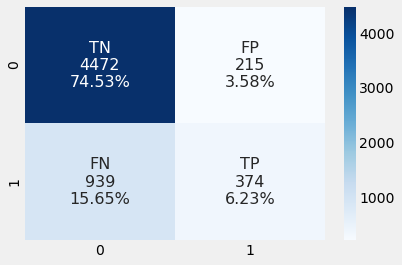

In [28]:
logreg3 = LogisticRegression(solver="liblinear", random_state=42).fit(X_tr3, y_tr)
y_pred_log_tr3 = logreg3.predict(X_tr3)
y_pred_log_val3 = logreg3.predict(X_val3)
get_metrics(X_tr3, y_tr, X_val3, y_val, y_pred_log_tr3, y_pred_log_val3, logreg3)

Training Accuracy:  0.9994285714285714
Validation Accuracy:  0.8181666666666667
Training F1 Score:  0.9987107864202837
Validation F1 Score:  0.47421686746987957
Training AUC Score:  0.9999983705150267
Validation AUC Score:  0.7545884965480348
Training Recall Score:  0.9982817869415808
Validation Recall Score:  0.3747143945163747
Training Precision Score:  0.999140154772141
Validation Precision Score:  0.6456692913385826
Training Average Precision Score:  0.9999940396835052
Validation Average Precision Score:  0.5146508591017449

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      1.00      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0  

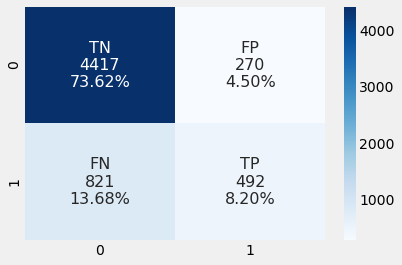

In [29]:
rfc3 = RandomForestClassifier().fit(X_tr3, y_tr)
y_pred_rfc_tr3 = rfc3.predict(X_tr3)
y_pred_rfc_val3 = rfc3.predict(X_val3)
get_metrics(X_tr3, y_tr, X_val3, y_val, y_pred_rfc_tr3, y_pred_rfc_val3, rfc3)


Training Accuracy:  0.9994761904761905
Validation Accuracy:  0.7213333333333334
Training F1 Score:  0.9988173314697344
Validation F1 Score:  0.3870967741935484
Training AUC Score:  0.9999991983985211
Validation AUC Score:  0.6068053605839815
Training Recall Score:  0.9976374570446735
Validation Recall Score:  0.4021325209444021
Training Precision Score:  1.0
Validation Precision Score:  0.37314487632508836
Training Average Precision Score:  0.9999948438742888
Validation Average Precision Score:  0.28112221901971524

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      1.00      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.83    

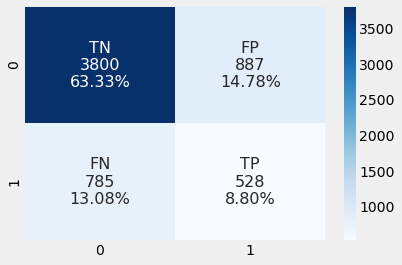

In [30]:
dtc3 = DecisionTreeClassifier().fit(X_tr3, y_tr)
y_pred_dtc_tr3 = dtc3.predict(X_tr3)
y_pred_dtc_val3 = dtc3.predict(X_val3)
get_metrics(X_tr3, y_tr, X_val3, y_val, y_pred_dtc_tr3, y_pred_dtc_val3, dtc3)

Training Accuracy:  0.8209047619047619
Validation Accuracy:  0.8188333333333333
Training F1 Score:  0.46735589859793236
Validation F1 Score:  0.4501770359129995
Training AUC Score:  0.7955235524706776
Validation AUC Score:  0.7765012070949919
Training Recall Score:  0.3543814432989691
Validation Recall Score:  0.3389185072353389
Training Precision Score:  0.6860706860706861
Validation Precision Score:  0.6701807228915663
Training Average Precision Score:  0.5645111486632847
Validation Average Precision Score:  0.5256890405633987

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     16344
           1       0.69      0.35      0.47      4656

    accuracy                           0.82     21000
   macro avg       0.76      0.65      0.68     21000
weighted avg       0.80      0.82      0.80     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0 

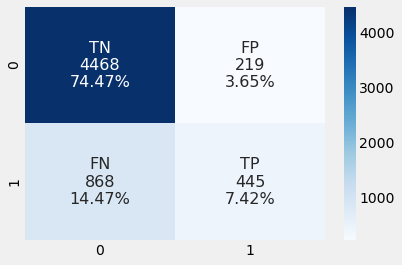

In [31]:
abc3 = AdaBoostClassifier().fit(X_tr3, y_tr)
y_pred_abc_tr3 = abc3.predict(X_tr3)
y_pred_abc_val3 = abc3.predict(X_val3)
get_metrics(X_tr3, y_tr, X_val3, y_val, y_pred_abc_tr3, y_pred_abc_val3, abc3)

Training Accuracy:  0.8288095238095238
Validation Accuracy:  0.8201666666666667
Training F1 Score:  0.5014561087227846
Validation F1 Score:  0.46345101939333666
Training AUC Score:  0.8150839098030658
Validation AUC Score:  0.7813532301023509
Training Recall Score:  0.38831615120274915
Validation Recall Score:  0.3549124143183549
Training Precision Score:  0.7076320939334638
Validation Precision Score:  0.667621776504298
Training Average Precision Score:  0.6122545155470038
Validation Average Precision Score:  0.5426942612475429

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     16344
           1       0.71      0.39      0.50      4656

    accuracy                           0.83     21000
   macro avg       0.78      0.67      0.70     21000
weighted avg       0.82      0.83      0.81     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0 

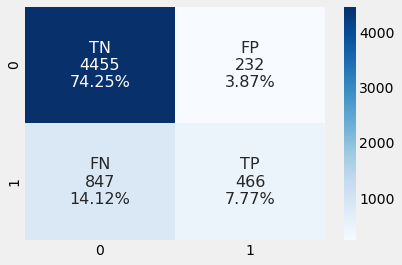

In [32]:
gbc3 = GradientBoostingClassifier().fit(X_tr3, y_tr)
y_pred_gbc_tr3 = gbc3.predict(X_tr3)
y_pred_gbc_val3 = gbc3.predict(X_val3)
get_metrics(X_tr3, y_tr, X_val3, y_val, y_pred_gbc_tr3, y_pred_gbc_val3, gbc3)

[12:50:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy:  0.9033333333333333
Validation Accuracy:  0.8125
Training F1 Score:  0.738940329218107
Validation F1 Score:  0.45148707947342764
Training AUC Score:  0.9616740469194953
Validation AUC Score:  0.7616216102908809
Training Recall Score:  0.617053264604811
Validation Recall Score:  0.3526275704493526
Training Precision Score:  0.9208333333333333
Validation Precision Score:  0.6273712737127372
Training Average Precision Score:  0.8968574652494508
Validation Average Precision Score:  0.5156839076040725

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     16344
           1       0.92  

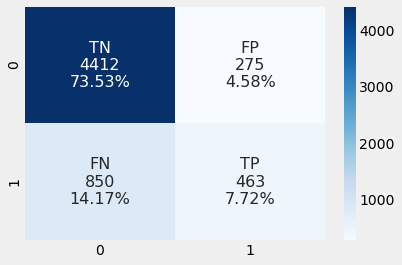

In [33]:
xgb3 = XGBClassifier().fit(X_tr3, y_tr)
y_pred_xgb_tr3 = xgb3.predict(X_tr3)
y_pred_xgb_val3 = xgb3.predict(X_val3)
get_metrics(X_tr3, y_tr, X_val3, y_val, y_pred_xgb_tr3, y_pred_xgb_val3, xgb3)

Best: 0.520523 using {'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}

Training Accuracy:  0.8087142857142857
Validation Accuracy:  0.807
Training F1 Score:  0.3875590791279158
Validation F1 Score:  0.3637362637362637
Training AUC Score:  0.7489338568921117
Validation AUC Score:  0.7470045243515997
Training Recall Score:  0.27298109965635736
Validation Recall Score:  0.2520944402132521
Training Precision Score:  0.6678928008407777
Validation Precision Score:  0.6528599605522682
Training Average Precision Score:  0.5199783170267793
Validation Average Precision Score:  0.495377643045376

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.96      0.89     16344
           1       0.67      0.27      0.39      4656

    accuracy                           0.81     21000
   macro avg       0.75      0.62      0.64     21000
weighted avg       0.79      0.81      0.78     21000


Validation Classification Report: 
            

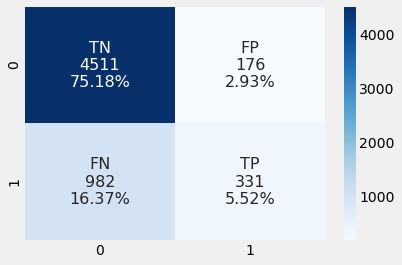

In [34]:
logreg = LogisticRegression()
params = {'C': [0.001, 0.01, 0.1, 1, 10], 
          'penalty': ['none', 'l1', 'l2', 'elasticnet'],
          'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']}
gslog = GridSearchCV(estimator = logreg,
                     param_grid = params,
                     scoring = 'average_precision',
                     cv = 10,
                     n_jobs = -1).fit(X_tr3, y_tr)
y_pred_gslog_tr = gslog.predict(X_tr3)
y_pred_gslog_val = gslog.predict(X_val3)
print("Best: %f using %s" % (gslog.best_score_, gslog.best_params_))
print("")
get_metrics(X_tr3, y_tr, X_val3, y_val, y_pred_gslog_tr, y_pred_gslog_val, gslog)

# Best: 0.520525 using {'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}

# logb = LogisticRegression(C=1, penalty='l1', solver='saga').fit(X_tr, y_tr)
# y_pred_logb_tr = logb.predict(X_tr)
# y_pred_logb_val = logb.predict(X_val)
# get_metrics(X_tr, y_tr, X_val, y_val, y_pred_logb_tr, y_pred_logb_val, logb)

Best: 0.523680 using {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 4}

Training Accuracy:  0.8261428571428572
Validation Accuracy:  0.819
Training F1 Score:  0.5036029911624744
Validation F1 Score:  0.47076023391812866
Training AUC Score:  0.7926903248961757
Validation AUC Score:  0.7580619109653495
Training Recall Score:  0.39776632302405496
Validation Recall Score:  0.36785986290936784
Training Precision Score:  0.6861800666913672
Validation Precision Score:  0.6535859269282814
Training Average Precision Score:  0.5691717892903193
Validation Average Precision Score:  0.5064675415803174

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.89     16344
           1       0.69      0.40      0.50      4656

    accuracy                           0.83     21000
   macro avg       0.77      0.67      0.70     21000
weighted avg       0.81      0.83      0.81     21000


Valida

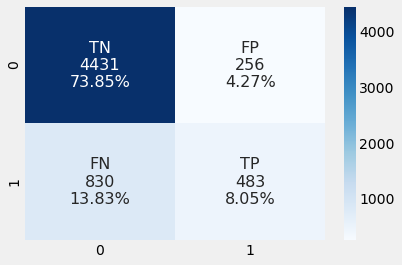

In [35]:
dtc = DecisionTreeClassifier()
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [2, 4, 6, 8, 10],
          'min_samples_leaf': [2, 4, 6, 8, 10], 
          'min_samples_split': [2, 4, 6, 8, 10]}
gsdtc = GridSearchCV(estimator = dtc,
                     param_grid = params,
                     scoring = 'average_precision',
                     cv = 5,
                     n_jobs = -1).fit(X_tr3, y_tr)
y_pred_gsdtc_tr = gsdtc.predict(X_tr3)
y_pred_gsdtc_val = gsdtc.predict(X_val3)
print("Best: %f using %s" % (gsdtc.best_score_, gsdtc.best_params_))
print("")
get_metrics(X_tr3, y_tr, X_val3, y_val, y_pred_gsdtc_tr, y_pred_gsdtc_val, gsdtc)

# Best: 0.523680 using {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 4}

# dtcb = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=10, min_samples_split=8).fit(X_tr, y_tr)
# y_pred_dtcb_tr = dtcb.predict(X_tr)
# y_pred_dtcb_val = dtcb.predict(X_val)
# get_metrics(X_tr, y_tr, X_val, y_val, y_pred_dtcb_tr, y_pred_dtcb_val, dtcb)

Best: 0.566061 using {'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 100, 'n_estimators': 600}

Training Accuracy:  0.8367619047619047
Validation Accuracy:  0.8223333333333334
Training F1 Score:  0.5270419426048565
Validation F1 Score:  0.47332015810276673
Training AUC Score:  0.8987761306312899
Validation AUC Score:  0.780351935178747
Training Recall Score:  0.4102233676975945
Validation Recall Score:  0.3648134044173648
Training Precision Score:  0.7368827160493827
Validation Precision Score:  0.6736990154711674
Training Average Precision Score:  0.7154172139364484
Validation Average Precision Score:  0.5405884203009684

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     16344
           1       0.74      0.41      0.53      4656

    accuracy                           0.84     21000
   macro avg       0.79      0.68      0.71     21000
weighted avg       0.83   

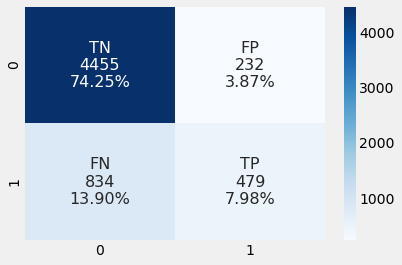

In [36]:
rfc = RandomForestClassifier()
params = {'n_estimators': [100, 200, 500, 1000],
          'max_depth': [5, 10, 20, 30],
          'min_samples_split': [2, 2, 10, , 100],
          'min_samples_leaf': [1, 2, 5, 10]}
gsrfc = GridSearchCV(estimator = rfc,
                     param_grid = params,
                     scoring = 'average_precision',
                     cv = 5,
                     n_jobs = -1).fit(X_tr3, y_tr)
y_pred_gsrfc_tr = gsrfc.predict(X_tr3)
y_pred_gsrfc_val = gsrfc.predict(X_val3)
print("Best: %f using %s" % (gsrfc.best_score_, gsrfc.best_params_))
print("")
get_metrics(X_tr3, y_tr, X_val3, y_val, y_pred_gsrfc_tr, y_pred_gsrfc_val, gsrfc)

# # Best: 0.558041 using {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1000}

# rfcb = RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=1000).fit(X_tr, y_tr)
# y_pred_rfcb_tr = rfcb.predict(X_tr)
# y_pred_rfcb_val = rfcb.predict(X_val)
# get_metrics(X_tr, y_tr, X_val, y_val, y_pred_rfcb_tr, y_pred_rfcb_val, rfcb)

Training Accuracy:  0.8201904761904761
Validation Accuracy:  0.8178333333333333
Training F1 Score:  0.45793855871375244
Validation F1 Score:  0.43688820195775374
Training AUC Score:  0.7887891604662134
Validation AUC Score:  0.7769743116341142
Training Recall Score:  0.3425687285223368
Validation Recall Score:  0.32292460015232294
Training Precision Score:  0.6904761904761905
Validation Precision Score:  0.6751592356687898
Training Average Precision Score:  0.5644032285794423
Validation Average Precision Score:  0.5316800328029031

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.96      0.89     16344
           1       0.69      0.34      0.46      4656

    accuracy                           0.82     21000
   macro avg       0.76      0.65      0.68     21000
weighted avg       0.80      0.82      0.80     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           

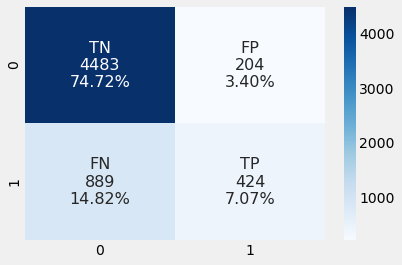

In [44]:
abc = AdaBoostClassifier()
params = {'n_estimators': [10, 50, 100, 200],
          'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5]}
gsabc = GridSearchCV(estimator = abc,
                     param_grid = params,
                     n_jobs = -1,
                     cv = 5,
                     scoring = 'average_precision').fit(X_tr3, y_tr)
y_pred_gsabc_tr = gsabc.predict(X_tr3)
y_pred_gsabc_val = gsabc.predict(X_val3)
print("Best: %f using %s" % (gsabc.best_score_, gsabc.best_params_))
print("")
get_metrics(X_tr3, y_tr, X_val3, y_val, y_pred_gsabc_tr, y_pred_gsabc_val, gsabc)

# Best: 0.542080 using {'learning_rate': 0.2, 'n_estimators': 200}

# abcb = AdaBoostClassifier(learning_rate=0.2, n_estimators=200).fit(X_tr, y_tr)
# y_pred_abcb_tr = abcb.predict(X_tr)
# y_pred_abcb_val = abcb.predict(X_val)
# get_metrics(X_tr, y_tr, X_val, y_val, y_pred_abcb_tr, y_pred_abcb_val, abcb)

Training Accuracy:  0.8289047619047619
Validation Accuracy:  0.8203333333333334
Training F1 Score:  0.5006254343293954
Validation F1 Score:  0.4652777777777778
Training AUC Score:  0.8079846971386665
Validation AUC Score:  0.7813919851882449
Training Recall Score:  0.3868127147766323
Validation Recall Score:  0.3571972581873572
Training Precision Score:  0.7093343836155966
Validation Precision Score:  0.6671408250355618
Training Average Precision Score:  0.6090909780964702
Validation Average Precision Score:  0.547995999890781

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     16344
           1       0.71      0.39      0.50      4656

    accuracy                           0.83     21000
   macro avg       0.78      0.67      0.70     21000
weighted avg       0.82      0.83      0.81     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0   

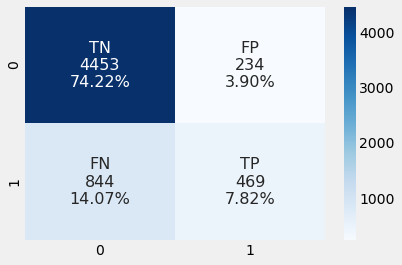

In [45]:
# gbc = GradientBoostingClassifier()
# params = {'n_estimators': [10, 100, 1000],
#           'learning_rate': [0.001, 0.01, 0.1],
#           'max_depth': [3, 7, 9]}
# gsgbc = GridSearchCV(estimator = gbc,
#                      param_grid = params, 
#                      n_jobs = -1, 
#                      cv = 5, 
#                      scoring = 'average_precision').fit(X_tr, y_tr)
# y_pred_gsgbc_tr = gsgbc.predict(X_tr)
# y_pred_gsgbc_val = gsgbc.predict(X_val)
# print("Best: %f using %s" % (gsgbc.best_score_, gsgbc.best_params_))
# print("")
# get_metrics(X_tr, y_tr, X_val, y_val, y_pred_gsgbc_tr, y_pred_gsgbc_tr, gsgbc)

# # Best: 0.554906 using {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000}

gbcb = GradientBoostingClassifier(learning_rate=0.01, max_depth=3, n_estimators=1000).fit(X_tr, y_tr)
y_pred_gbcb_tr = gbcb.predict(X_tr)
y_pred_gbcb_val = gbcb.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_gbcb_tr, y_pred_gbcb_val, gbcb)

In [46]:
# xgb = XGBClassifier()
# params = {'n_estimators': [50, 100, 150, 200], 
#           'max_depth': [3, 5, 7, 10], 
#           'min_child_weight': [2, 3, 4, 5]}
# gsxgb = GridSearchCV(estimator = xgb,
#                      param_grid = params,
#                      scoring = 'average_precision',
#                      cv = 5,
#                      n_jobs = -1).fit(X_tr, y_tr)
# y_pred_gsxgb_tr = gsxgb.predict(X_tr)
# y_pred_gsxgb_val = gsxgb.predict(X_val)
# print("Best: %f using %s" % (gsxgb.best_score_, gsxgb.best_params_))
# print("")
# get_metrics(X_tr, y_tr, X_val, y_val, y_pred_gsxgb_tr, y_pred_gsxgb_val, gsxgb)

# Best: 0.550954 using {'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50}

xgbb = XGBClassifier(max_depth=3, min_child_weight=3, n_estimators=50).fit(X_tr, y_tr)
y_pred_xgbb_tr = xgbb.predict(X_tr)
y_pred_xgbb_val = xgbb.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_xgbb_tr, y_pred_xgbb_val, xgbb)

ValueError: DataFrame.dtypes for data must be int, float, bool or categorical.  When
                categorical type is supplied, DMatrix parameter
                `enable_categorical` must be set to `True`.ID, LIMIT_BAL, SEX, EDUCATION, MARRIAGE, AGE, PAY_0, PAY_2, PAY_3, PAY_4, PAY_5, PAY_6, BILL_AMT1, BILL_AMT2, BILL_AMT3, BILL_AMT4, BILL_AMT5, BILL_AMT6, PAY_AMT1, PAY_AMT2, PAY_AMT3, PAY_AMT4, PAY_AMT5, PAY_AMT6

In [ ]:
data = {'Accuracy': [accuracy(y_val, y_pred_logb_val), 
                     accuracy(y_val, y_pred_dtcb_val), 
                     accuracy(y_val, y_pred_rfcb_val), 
                     accuracy(y_val, y_pred_abcb_val), 
                     accuracy(y_val, y_pred_gbcb_val),
                     accuracy(y_val, y_pred_xgbb_val)],
        'F1 Score': [f1(y_val, y_pred_logb_val), 
                     f1(y_val, y_pred_dtcb_val), 
                     f1(y_val, y_pred_rfcb_val), 
                     f1(y_val, y_pred_abcb_val), 
                     f1(y_val, y_pred_gbcb_val),
                     f1(y_val, y_pred_xgbb_val)],
        'ROC AUC': [auc(X_val, y_val, logb),
                    auc(X_val, y_val, dtcb),
                    auc(X_val, y_val, rfcb),
                    auc(X_val, y_val, abcb),
                    auc(X_val, y_val, gbcb),
                    auc(X_val, y_val, xgbb)],
        'Recall': [recall(y_val, y_pred_logb_val), 
                   recall(y_val, y_pred_dtcb_val), 
                   recall(y_val, y_pred_rfcb_val), 
                   recall(y_val, y_pred_abcb_val),
                   recall(y_val, y_pred_gbcb_val),
                   recall(y_val, y_pred_xgbb_val)],
        'Precision': [precision(y_val, y_pred_logb_val), 
                      precision(y_val, y_pred_dtcb_val), 
                      precision(y_val, y_pred_rfcb_val), 
                      precision(y_val, y_pred_abcb_val),
                      precision(y_val, y_pred_gbcb_val),
                      precision(y_val, y_pred_xgbb_val)],
        'PR AUC': [aps(X_val, y_val, logb),
                   aps(X_val, y_val, dtcb),
                   aps(X_val, y_val, rfcb),
                   aps(X_val, y_val, abcb),
                   aps(X_val, y_val, gbcb),
                   aps(X_val, y_val, xgbb)]}
scores3 = pd.DataFrame(data=data, index = ['Logistic with GridSearchCV', 
                                          'Random Forest with GridSearchCV', 
                                          'Decision Tree with GridSearchCV', 
                                          'AdaBoost with GridSearchCV', 
                                          'Gradient Boosting with GridSearchCV',
                                          'XGBoost with GridSearchCV'])